# Image Superresolution: CNN's

In this notebook, I am going to implement this [paper](https://arxiv.org/pdf/1603.08155.pdf). Image Superesolution takes a low resolution input photo and produces a high resolution version of that. Many traditional image processing tasks can be framed as image transformation problems, where a system recievs some input image and produces an output image. Examples from image processing include denoising, super-resolution, and colorization, where the input is a degraded image (noisy, low-resolution, or grayscale) and the output is a high-quality color image. 

Then I going to deploy this trained model in the cloud as a service that will be used by my web app. 

This way we will collectively learn how to start from data and intuition, do some math and build/ experiment with a machine learning model. But then we will not stop there and deploy this model in production so that our users will be able to take benifit of this tool. This will be an invaluable experience. 

From now on we will be doing this loop for every project that we do. 

## Key takeaways from the paper

This paper introduces some new terminology, such as perceptual loss. Which same as mean squared error between actual high res vgg conv embeddings and generated image vgg conv embeddings.

The overall architecture for this problem is depicted in the image below.

## Implementation 

- I learnt about bcolz iterator, which is a handy little class to read bcolz arrays on disk in a generator fashion so that we do not have to load up all the data at once in the memory.

#### Import dependencies and preprocessing

In [1]:
import os 

In [2]:
BASE_DIR = os.getcwd()

In [3]:
dpath = os.path.join(BASE_DIR, 'data')

In [4]:
!ls

__pycache__		 data  requirements.txt  vgg16_avg.py
bcolz_array_iterator.py  img   sr-keras.ipynb


In [5]:
dpath

'/home/nbuser/vineet/superresolution/data'

In [6]:
import keras
from keras.models import Model, Sequential 
from keras.layers import Conv2D, Activation, BatchNormalization, Add, Conv2DTranspose, Input, Lambda
import keras.backend as K

Using TensorFlow backend.


In [7]:
from vgg16_avg import VGG16_Avg
import numpy as np

In [8]:
%matplotlib inline

In [9]:
import matplotlib.pyplot as plt

In [10]:
import bcolz

In [11]:
from bcolz_array_iterator import BcolzArrayIterator

arr_lr is a sample of imagenet files in low resoltuion, and arr_hr is their high-resolution version. 

In [12]:
arr_lr = bcolz.open(dpath + '/trn_resized_72.bc', mode='r')

So there are 19439 low resolution RGB pictures of size 72x72. (19439, 72, 72, 3)

In [13]:
arr_lr.shape

(19439, 72, 72, 3)

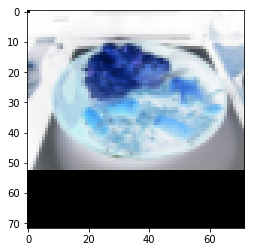

In [14]:
plt.imshow(arr_lr[7])

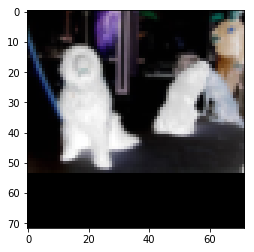

In [15]:
plt.imshow(arr_lr[199])

In [16]:
arr_hr = bcolz.open(dpath + '/trn_resized_288.bc', mode='r')

In [17]:
arr_hr.shape

(19439, 288, 288, 3)

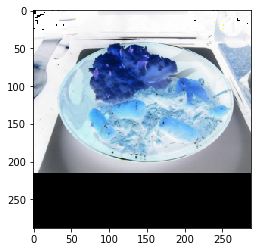

In [18]:
plt.imshow(arr_hr[7])

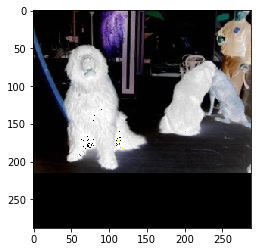

In [19]:
plt.imshow(arr_hr[199])

#### Utilities

In [20]:
def conv_block(x, filters, kernel_size, strides = (2,2), padding='same', act =True ):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
    x= BatchNormalization()(x)
    return Activation('relu')(x) if act else x 

In [21]:
def res_block(inp, nf=64):
    x = conv_block(inp, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act = True)
    return Add()([x,inp])

In [22]:
def deconv_block(x, filters, kernel_size, strides, ):
    x = Conv2DTranspose(filters, kernel_size, )
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [23]:
def up_block(x,filters,size):
    x = keras.layers.UpSampling2D()(x)
    x = Conv2D(filters, size, strides=(1,1), padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [24]:
inp = Input(shape = arr_lr.shape[1:])

In [25]:
inp=Input(arr_lr.shape[1:])
x=conv_block(inp, 64, (9,9), (1,1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x = Conv2D(3,9,strides = (1,1), padding='same')(x)
outp = Lambda(lambda x: (x+1)*127.5)(x)

Now we have our upsampling model. All we have to do now is to compute the loss function and train the model and we are good to go.

In [26]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [27]:
vgg_inp = Input(arr_hr.shape[1:])
vgg = VGG16_Avg(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

In [28]:
for l in vgg.layers: l.trainable = False

In [29]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [30]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv1').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])

In [31]:
vgg_content.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [32]:
vgg1 = vgg_content(vgg_inp)

In [33]:
vgg2 = vgg_content(outp)

In [34]:
def mean_sqr_b(diff): 
    dims = list(range(1,K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [35]:
w=[0.1, 0.8, 0.1]
def content_fn(x): 
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [36]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))

On an average it is taking 52 minutes per epoch. 

In [37]:
m_sr.compile('adam', 'mse')
m_sr.fit([arr_lr, arr_hr], targ, 8, 2)

Epoch 1/2
19439/19439 [==============================] - 3096s - loss: 13132.2497  
Epoch 2/2
19439/19439 [==============================] - 3045s - loss: 10062.7403  


In [41]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 16, 1)

Epoch 1/1
19439/19439 [==============================] - 2750s - loss: 8676.8607  


In [42]:
top_model = Model(inp, outp)

In [47]:
p = top_model.predict(arr_lr[15:16])

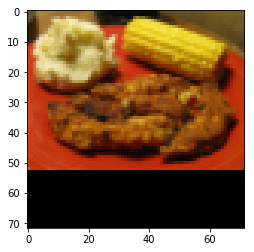

In [48]:
plt.imshow(arr_lr[15].astype('uint8'))

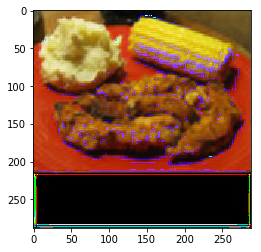

In [49]:
plt.imshow(p[0].astype('uint8'))

In [51]:
p.shape

(1, 288, 288, 3)

In [52]:
top_model.save_weights(dpath+'sr_final.h5')

In [54]:
json_model = top_model.to_json()

In [55]:
json_model 

'{"class_name": "Model", "config": {"name": "model_3", "layers": [{"name": "input_2", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 72, 72, 3], "dtype": "float32", "sparse": false, "name": "input_2"}, "inbound_nodes": []}, {"name": "conv2d_1", "class_name": "Conv2D", "config": {"name": "conv2d_1", "trainable": true, "filters": 64, "kernel_size": [9, 9], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["input_2", 0, 0, {}]]]}, {"name": "batch_normalization_1", "class_name": "BatchNormalization", "config": {"name": "batch_normal

In [56]:
import json 

In [57]:
with open('data.json', 'w') as f:
     json.dump(json_model, f)

In [ ]:
!